In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# Creators by lifecycle stage (daily)

```sql
select
  day,
  lifecycle_stage,
  sum(has_live_broadcast) as creators_live,
  count(1) as creators_total
from cubes.creator_lifecycle_stage_daily
where day >= '2015-01-01'
group by 1, 2
order by 1, 2
"""

-- Transition probabilities

with agg as (
   select
     a.day,
     a.lifecycle_stage as start_stage,
     b.lifecycle_stage as end_stage,
     count(1) as transitions
   from cubes.creator_lifecycle_stage_daily a
   inner join cubes.creator_lifecycle_stage_daily b
     on b.channel_id = a.channel_id
       and b.day = a.day + interval '1 day'
   where a.day >= '2015-01-01'
     and b.day >= '2015-01-01'
   group by 1, 2, 3
)
 
select
  day,
  start_stage,
  end_stage,
  transitions::float / sum(transitions) over (partition by day, start_stage) as prob_transition
from agg
order by 1, 2, 3
```

In [12]:
creators_daily = pd.read_csv("./creators/creators_daily.csv", parse_dates=['day'])
transition_probs = pd.read_csv("./creators/transition_probs.csv", parse_dates=['day'])

In [53]:
creators_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18469 entries, 0 to 18468
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   day              18469 non-null  datetime64[ns]
 1   lifecycle_stage  18469 non-null  object        
 2   creators_live    18469 non-null  int64         
 3   creators_total   18469 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 577.3+ KB


In [13]:
creators_daily.head()

,day,lifecycle_stage,creators_live,creators_total
0,2015-01-01,Born,27057,27057
1,2015-01-01,Cold,0,1283143
2,2015-01-01,Frozen,0,654883
3,2015-01-01,Large Full-Time,492,716
4,2015-01-01,Large Infrequent,18,409


In [14]:
transition_probs.head()

,day,start_stage,end_stage,prob_transition
0,2015-01-01,Born,New,1.000000
1,2015-01-01,Cold,Cold,0.976540
2,2015-01-01,Cold,Frozen,0.014682
3,2015-01-01,Cold,Reengaged,0.008778
4,2015-01-01,Frozen,Born,0.000026


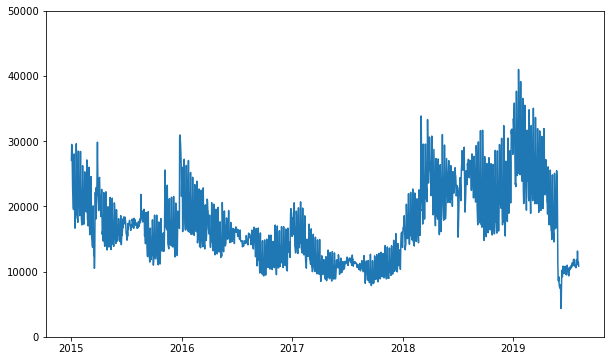

In [25]:
# Arrival rates into Born
born = creators_daily.query('lifecycle_stage == "Born"')
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(born['day'], born['creators_total'])
ax.set_ylim(0, 50000);

In [26]:
# Parameters
prediction_floor = 0    # Predicted variable lower bound
prediction_cap = 50000  # Predicted variable upper bound

In [35]:
born_historical = born.rename({'day': 'ds',             # Time variable
                               'creators_total': 'y'},  # Predicted variable
                              axis='columns').assign(floor = prediction_floor) \
                                             .assign(cap = prediction_cap)

In [36]:
born_historical.head()

,ds,lifecycle_stage,creators_live,y,floor,cap
0,2015-01-01,Born,27057,27057,0,50000
11,2015-01-02,Born,29491,29491,0,50000
22,2015-01-03,Born,28833,28833,0,50000
33,2015-01-04,Born,25227,25227,0,50000
44,2015-01-05,Born,22494,22494,0,50000


In [39]:
model = Prophet(
    daily_seasonality=True,                   # Boolean to specify whether to use Daily seasonality
    growth="logistic",                        # Used to saturate forecast between floor & cap
    changepoint_range=0.9,                    # Percent of historical data to use for training
    changepoint_prior_scale=0.01,             # Measure of model flexibility (over/underfit to trend changes)
    interval_width=0.90                       # Level for confidence interval (uncertainty in trend)
    # yearly_seasonality=5,                   # Frequency of seasonal changes (default = 10)
    # seasonality_mode="multiplicative"       # Multiplicative seasonality if error grows over time
    # mcmc_samples=300                        # Bayesian sampling to generate uncertainty in seasonality
  ).fit(born_historical)

In [40]:
born_future = model.make_future_dataframe(periods=1000)    # Prediction range (days)
born_future['floor'] = 0                                   # Forecast lower bound
born_future['cap'] = 50000                                 # Forecast upper bound

In [41]:
born_pred = model.predict(born_future)

In [42]:
from prophet.plot import add_changepoints_to_plot

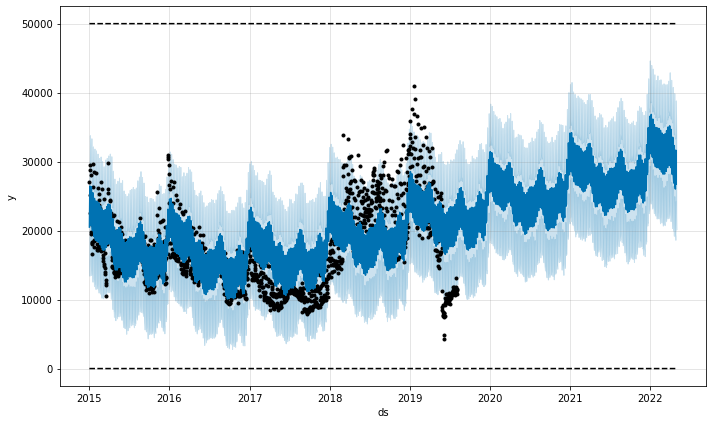

In [43]:
fig = model.plot(born_pred)

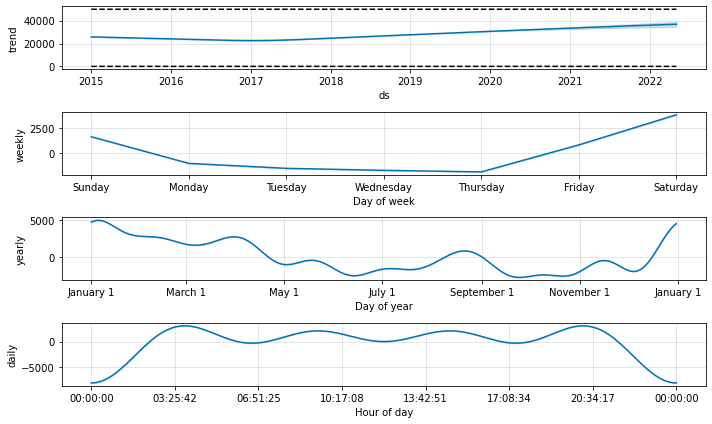

In [44]:
fig = model.plot_components(born_pred, figsize=(10,6))

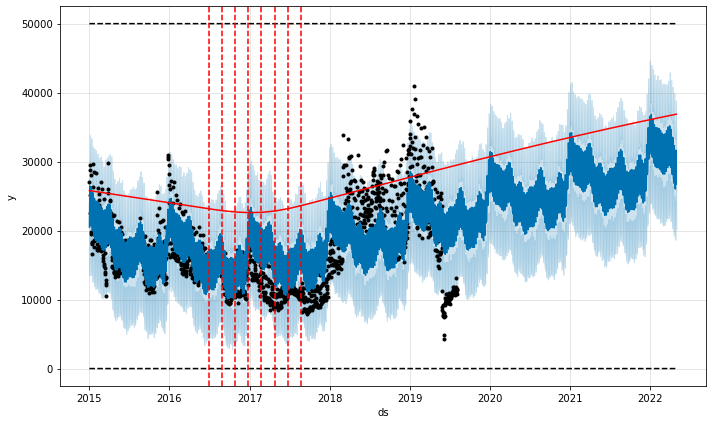

In [45]:
fig = model.plot(born_pred)
a = add_changepoints_to_plot(fig.gca(), model, born_pred)

In [47]:
# Cross validation
from prophet.diagnostics import cross_validation

born_cv = cross_validation(model,
                           initial=pd.to_timedelta(730, unit="D"),
                           period=pd.to_timedelta(180, unit="D"),
                           horizon=pd.to_timedelta(365, unit="D")
                          )
born_cv.head()

INFO:prophet:Making 4 forecasts with cutoffs between 2017-02-12 00:00:00 and 2018-08-06 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-02-13,14940.409695,12021.073225,17962.409680,12492,2017-02-12
1,2017-02-14,14651.715737,11650.605410,17830.560659,11454,2017-02-12
2,2017-02-15,14235.346821,11151.175144,17503.213072,11947,2017-02-12
3,2017-02-16,14121.846594,11170.304528,17183.681685,10524,2017-02-12
4,2017-02-17,16556.921344,13475.615110,19560.215416,12570,2017-02-12


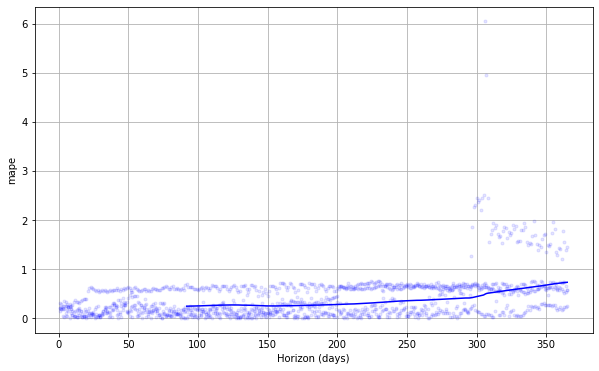

In [52]:
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

born_perf = performance_metrics(born_cv)
fig, ax = plt.subplots(figsize=(10,6))
plot_cross_validation_metric(born_cv, metric="mape", rolling_window=0.25, ax=ax);

In [62]:
revenue_data = pd.read_csv("./creators/revenue_per_khw.csv", parse_dates=['day'])

In [63]:
revenue_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10904 entries, 0 to 10903
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   day                                  10904 non-null  datetime64[ns]
 1   country                              10904 non-null  object        
 2   country_tier                         10904 non-null  object        
 3   hours_watched                        10904 non-null  float64       
 4   paid_bits_revenue_net                10904 non-null  float64       
 5   unpaid_bits_revenue_net              10904 non-null  float64       
 6   channel_subs_revenue_net             10904 non-null  float64       
 7   community_gift_subs_revenue_net      10904 non-null  float64       
 8   single_gift_subs_revenue_net         10904 non-null  float64       
 9   prime_subs_revenue_net               10904 non-null  float64       
 10  ad_revenue

## Revenue / kHW by country tier

In [159]:
grouped_by_day_tier = revenue_data.groupby(['day', 'country_tier'])

tidy_rev = pd.merge(grouped_by_day_tier \
           .apply(lambda x: 1000 * sum(x['revenue_total']) / sum(x['hours_watched']))
           .reset_index(name='total'),
         grouped_by_day_tier \
           .apply(lambda x: 1000 * sum(x['ad_revenue_net']) / sum(x['hours_watched']))
           .reset_index(name='ads')) \
  .merge(grouped_by_day_tier \
           .apply(lambda x: 1000 * (x['prime_subs_revenue_net']
                + x['channel_subs_revenue_net']
                + x['community_gift_subs_revenue_net']
                + x['single_gift_subs_revenue_net']).sum() / x['hours_watched'].sum())
           .reset_index(name='subs')) \
  .merge(grouped_by_day_tier \
           .apply(lambda x: 1000 * (x['paid_bits_revenue_net']
                + x['unpaid_bits_revenue_net']).sum() / x['hours_watched'].sum())
           .reset_index(name='bits'))

In [178]:
tidy_rev = pd.melt(
    frame=tidy_rev,
    value_vars=tidy_rev.columns[2:],
    id_vars=['day', 'country_tier'],
    value_name='rev_per_khw',
    var_name='product'
).sort_values(by=['day','country_tier'])

In [179]:
tidy_rev

,day,country_tier,product,rev_per_khw
0,2018-08-01,T1,total,21.713521
1128,2018-08-01,T1,ads,13.502471
2256,2018-08-01,T1,subs,3.321386
3384,2018-08-01,T1,bits,4.889664
1,2018-08-01,T2,total,6.487889
...,...,...,...,...
4510,2019-08-11,T2,bits,0.908346
1127,2019-08-11,T3,total,4.603239
2255,2019-08-11,T3,ads,-0.002271
3383,2019-08-11,T3,subs,4.008451


In [224]:
import seaborn as sns
import matplotlib.pyplot as plt

In [231]:
plt.style.use('ggplot')

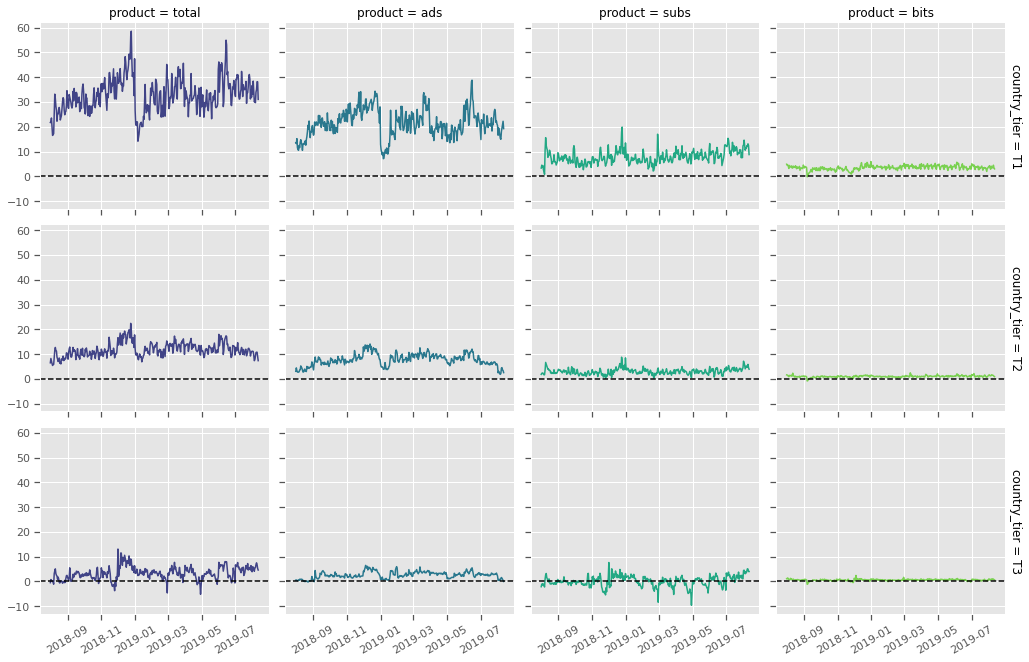

In [245]:
grid = sns.FacetGrid(
    tidy_rev,
    row='country_tier',
    col='product',
    hue='product',
    palette='viridis',
    height=3,
    aspect=1.2,
    margin_titles=True
)
grid.map(plt.plot, 'day', 'rev_per_khw')
grid.map(plt.axhline, y=0, ls='--', c='k')
#for ax in grid.axes.flatten():
#    ax.axhline(0, ls='-')
grid.set_xticklabels(rotation=30);

## Bits Breakdown

In [253]:
bits_per_khw = pd.merge(
         grouped_by_day_tier \
           .apply(lambda x: 1000 * x['paid_bits_revenue_net'].sum() / x['hours_watched'].sum())
           .reset_index(name='paid_bits_per_khw'),
         grouped_by_day_tier \
           .apply(lambda x: 1000 * x['unpaid_bits_revenue_net'].sum() / x['hours_watched'].sum())
           .reset_index(name='unpaid_bits_per_khw')) 

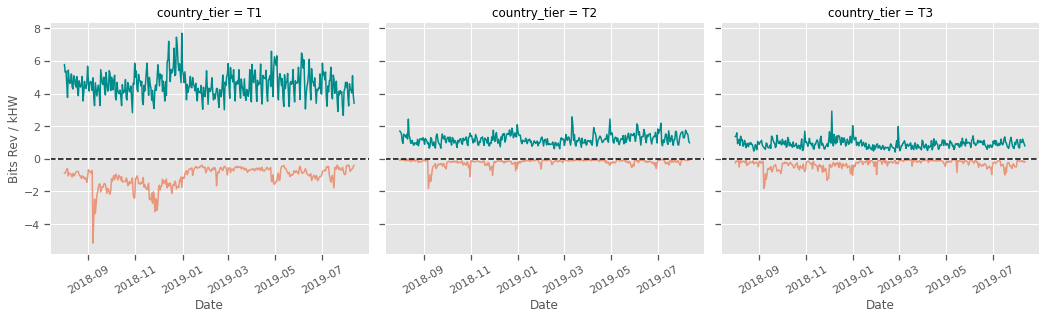

In [271]:
grid = sns.FacetGrid(
    bits_per_khw,
    col='country_tier',
    palette='viridis',
    height=4,
    aspect=1.2
)
grid.map(plt.plot, 'day', 'paid_bits_per_khw', color='darkcyan')
grid.map(plt.plot, 'day', 'unpaid_bits_per_khw', color='darksalmon')
grid.map(plt.axhline, y=0, ls='--', c='k')
grid.set_ylabels('Bits Rev / kHW')
grid.set_xlabels('Date')
grid.set_xticklabels(rotation=30);

## Subs Breakdown

In [273]:
tidy_subs = pd.merge(
         grouped_by_day_tier \
           .apply(lambda x: 1000 * x['prime_subs_revenue_net'].sum() / x['hours_watched'].sum())
           .reset_index(name='prime_subs'),
         grouped_by_day_tier \
           .apply(lambda x: 1000 * x['channel_subs_revenue_net'].sum() / x['hours_watched'].sum())
           .reset_index(name='paid_subs')) \
         .merge(
         grouped_by_day_tier \
           .apply(lambda x: 1000 * x['community_gift_subs_revenue_net'].sum() / x['hours_watched'].sum())
           .reset_index(name='community_subs')) \
         .merge(
         grouped_by_day_tier \
           .apply(lambda x: 1000 * x['single_gift_subs_revenue_net'].sum() / x['hours_watched'].sum())
           .reset_index(name='gift_subs'))

In [275]:
tidy_subs = pd.melt(
    frame=tidy_subs,
    value_vars=tidy_subs.columns[2:],
    id_vars=['day', 'country_tier'],
    value_name='rev_per_khw',
    var_name='product'
).sort_values(by=['day', 'country_tier'])

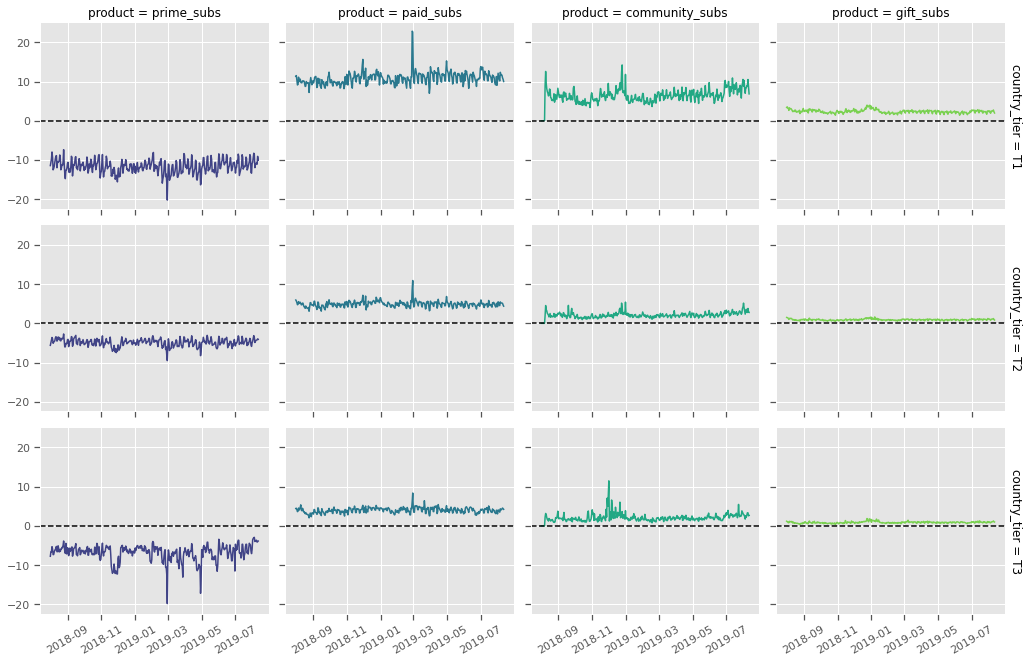

In [277]:
grid = sns.FacetGrid(
    tidy_subs,
    row='country_tier',
    col='product',
    hue='product',
    palette='viridis',
    height=3,
    aspect=1.2,
    margin_titles=True
)
grid.map(plt.plot, 'day', 'rev_per_khw')
grid.map(plt.axhline, y=0, ls='--', c='k')
grid.set_xticklabels(rotation=30);

## Ads Breakdown

In [283]:
ads_per_khw = grouped_by_day_tier \
           .apply(lambda x: 1000 * x['ad_revenue_net'].sum() / x['hours_watched'].sum()) \
           .reset_index(name='ads')

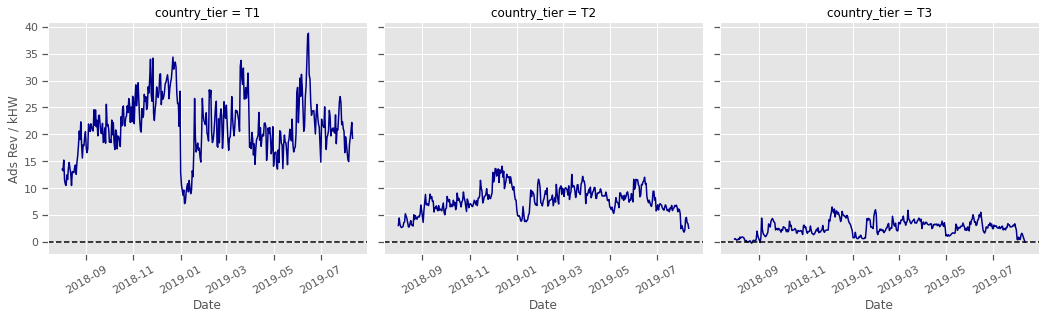

In [288]:
grid = sns.FacetGrid(ads_per_khw,
                     col='country_tier',
                     palette='viridis',
                     height=4,
                     aspect=1.2)
grid.map(plt.plot, 'day', 'ads', color='darkblue')
grid.map(plt.axhline, y=0, ls='--', c='k')
grid.set_ylabels('Ads Rev / kHW')
grid.set_xlabels('Date')
grid.set_xticklabels(rotation=30);

# FORECASTING

### Revenue / kHW

In [291]:
rev_df = revenue_data.groupby('day') \
                     .apply(lambda x: 1000 * x['revenue_total'].sum() / x['hours_watched'].sum()) \
                     .reset_index(name='y') \
                     .rename({'day': 'ds'}, axis='columns')

In [295]:
rev_df

,ds,y
0,2018-08-01,14.450093
1,2018-08-02,15.349448
2,2018-08-03,16.258932
3,2018-08-04,13.552813
4,2018-08-05,11.421663
...,...,...
371,2019-08-07,23.651691
372,2019-08-08,24.606068
373,2019-08-09,26.467729
374,2019-08-10,25.673701


In [297]:
m_rev = Prophet(
    daily_seasonality=False,
    yearly_seasonality=True,
    interval_width=0.90
).fit(rev_df)

In [300]:
future_rev = m_rev.make_future_dataframe(periods=1000)
forecast_rev = m_rev.predict(future_rev)

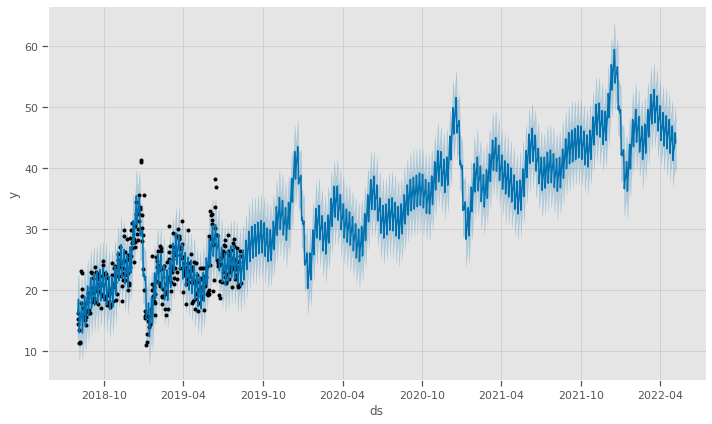

In [302]:
fig = m_rev.plot(forecast_rev)

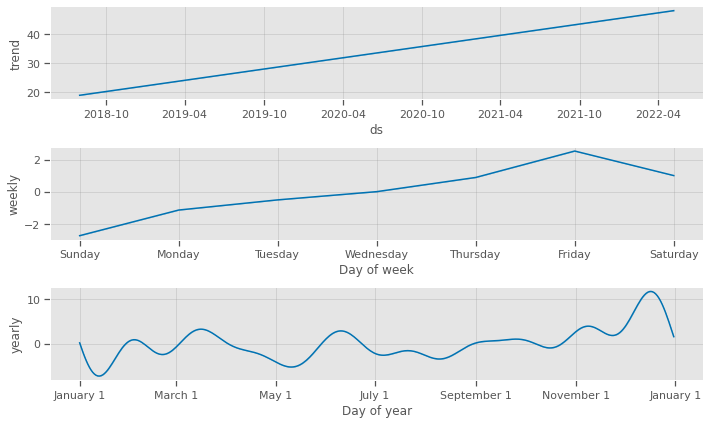

In [303]:
fig = m_rev.plot_components(forecast_rev, figsize=(10,6))

In [304]:
max_date = rev_df['ds'].max()

### Write predictions to data frame

In [354]:
columns = ['day', 'series', 'type', 'estimate', 
           'lower_bound', 'upper_bound']

rev_forecast_df = pd.DataFrame()
rev_forecast_df['day'] = rev_df['ds'].astype('datetime64[D]')
rev_forecast_df['series'] = 'total_rev_per_khw'
rev_forecast_df['type'] = 'actual'
rev_forecast_df['estimate'] = rev_df['y']
rev_forecast_df['lower_bound'] = rev_df['y']
rev_forecast_df['upper_bound'] = rev_df['y']
rev_forecast_df = rev_forecast_df[columns]

In [355]:
rev_forecast_df = rev_forecast_df.append(
    forecast_rev.query('ds > @max_date') \
        .assign(day=forecast_rev['ds'])
        .assign(series='total_rev_per_khw') \
        .assign(type='forecast') \
        .assign(estimate=forecast_rev['yhat']) \
        .assign(lower_bound=forecast_rev['yhat_lower']) \
        .assign(upper_bound=forecast_rev['yhat_upper'])[columns]
)

In [356]:
all_forecasts = rev_forecast_df

In [357]:
all_forecasts.head(3)

,day,series,type,estimate,lower_bound,upper_bound
0,2018-08-01,total_rev_per_khw,actual,14.450093,14.450093,14.450093
1,2018-08-02,total_rev_per_khw,actual,15.349448,15.349448,15.349448
2,2018-08-03,total_rev_per_khw,actual,16.258932,16.258932,16.258932


In [358]:
all_forecasts.tail(3)

,day,series,type,estimate,lower_bound,upper_bound
1373,2022-05-05,total_rev_per_khw,forecast,44.269756,39.870622,48.273618
1374,2022-05-06,total_rev_per_khw,forecast,45.794714,41.525825,49.775012
1375,2022-05-07,total_rev_per_khw,forecast,44.165254,39.508862,48.228224


## Revenue / kHW by country Tier

In [547]:
from typing import List, Dict, Any, Callable

In [519]:
country_tiers = revenue_data['country_tier'].unique()
all_forecasts = pd.DataFrame()

In [554]:
prophet_params = {
    'daily_seasonality': False,
    'yearly_seasonality': True,
    'interval_width': 0.90
}
        
def kHW_by_country_tier(
    revenue_data: pd.DataFrame,
    country_tiers: List[str],
    metric_func: Callable,
    metric_label: str,
    prophet_params: Dict[str, Any]) -> pd.DataFrame:
    
    forecasts = pd.DataFrame()
    
    for tier in country_tiers:
        rev_tier_df = revenue_data.query(f'country_tier == "{tier}"') \
                                  .groupby('day') \
                                  .apply(metric_func) \
                                  .reset_index(name='y') \
                                  .rename({'day': 'ds'}, axis='columns') # ['ds', 'y']

        m_rev = Prophet(**prophet_params).fit(rev_tier_df)
        future_rev = m_rev.make_future_dataframe(periods=1000)
        forecast_rev = m_rev.predict(future_rev)

        rev_tier_forecast_df = rev_tier_df.assign(day=rev_tier_df['ds'].astype('datetime64[D]')) \
                                          .assign(series=f'{metric_label}_{tier}_per_khw') \
                                          .assign(type='actual') \
                                          .assign(estimate = rev_tier_df['y']) \
                                          .assign(lower_bound = rev_tier_df['y']) \
                                          .assign(upper_bound = rev_tier_df['y'])[columns]
        
        #forecast_rev = forecast_rev.query('ds > @max_date')
        rev_tier_forecast_df = rev_tier_forecast_df.append(forecast_rev \
                                          .query('ds > @max_date') \
                                          .assign(day=forecast_rev['ds'].astype('datetime64[D]'))
                                          .assign(series=f'{metric_label}_{tier}_per_khw') \
                                          .assign(type='forecast') \
                                          .assign(estimate=forecast_rev['yhat']) \
                                          .assign(lower_bound=forecast_rev['yhat_lower']) \
                                          .assign(upper_bound=forecast_rev['yhat_upper'])[columns])
        
        forecasts = forecasts.append(rev_tier_forecast_df)
    return forecasts

In [520]:
func = lambda x: 1000 * x['revenue_total'].sum() / x['hours_watched'].sum())

all_forecasts = kHW_by_country_tier(revenue_data,
                                    country_tiers,
                                    func,
                                    'total_rev',
                                    prophet_params)

## Ads Revenue / kHW by Country Tier

In [522]:
func = lambda x: 1000 * x['ad_revenue_net'].sum() / x['hours_watched'].sum())


all_forecasts = all_forecasts.append(kHW_by_country_tier(revenue_data,
                                                         country_tiers,
                                                         func,
                                                         'ad_rev',
                                                         prophet_params)
                                    )

## Bits Revenue / kHW by Country Tier

In [555]:
func = lambda x: 1000 * (x['paid_bits_revenue_net'] +
                         x['unpaid_bits_revenue_net']).sum() / x['hours_watched'].sum()

all_forecasts = all_forecasts.append(kHW_by_country_tier(revenue_data,
                                                         country_tiers,
                                                         func,
                                                         'bits_rev',
                                                         prophet_params)
                                    )

## Subs Revenue / kHW by Country Tier

In [558]:
func = lambda x: 1000 * (x['prime_subs_revenue_net'] +
                         x['channel_subs_revenue_net'] +
                         x['community_gift_subs_revenue_net'] +
                         x['single_gift_subs_revenue_net']).sum() / x['hours_watched'].sum()

all_forecasts = all_forecasts.append(kHW_by_country_tier(revenue_data,
                                                         country_tiers,
                                                         func,
                                                         'subs_rev',
                                                         prophet_params)
                                    )

## Paid Bits Revenue / kHW by Country Tier

In [560]:
func = lambda x: 1000 * x['paid_bits_revenue_net'].sum() / x['hours_watched'].sum()

all_forecasts = all_forecasts.append(kHW_by_country_tier(revenue_data,
                                                         country_tiers,
                                                         func,
                                                         'paid_bits_rev',
                                                         prophet_params)
                                    )

## Unpaid Bits Revenue / kHW by Country Tier

In [562]:
func = lambda x: 1000 * x['unpaid_bits_revenue_net'].sum() / x['hours_watched'].sum()

all_forecasts = all_forecasts.append(kHW_by_country_tier(revenue_data,
                                                         country_tiers,
                                                         func,
                                                         'unpaid_bits_rev',
                                                         prophet_params)
                                    )

## Prime Subs Revenue / kHW by Country Tier

In [563]:
func = lambda x: 1000 * x['prime_subs_revenue_net'].sum() / x['hours_watched'].sum()

all_forecasts = all_forecasts.append(kHW_by_country_tier(revenue_data,
                                                         country_tiers,
                                                         func,
                                                         'prime_subs_rev',
                                                         prophet_params)
                                    )

## Paid Subs Revenue / kHW by Country Tier

In [565]:
func = lambda x: 1000 * x['channel_subs_revenue_net'].sum() / x['hours_watched'].sum()

all_forecasts = all_forecasts.append(kHW_by_country_tier(revenue_data,
                                                         country_tiers,
                                                         func,
                                                         'paid_subs_rev',
                                                         prophet_params)
                                    )

## Community Subs Revenue / kHW by Country Tier

In [567]:
func = lambda x: 1000 * x['community_gift_subs_revenue_net'].sum() / x['hours_watched'].sum()

all_forecasts = all_forecasts.append(kHW_by_country_tier(revenue_data,
                                                         country_tiers,
                                                         func,
                                                         'community_subs_rev',
                                                         prophet_params)
                                    )

## Single Subs Revenue / kHW by Country Tier

In [568]:
func = lambda x: 1000 * x['single_gift_subs_revenue_net'].sum() / x['hours_watched'].sum()

all_forecasts = all_forecasts.append(kHW_by_country_tier(revenue_data,
                                                         country_tiers,
                                                         func,
                                                         'single_gift_subs_rev',
                                                         prophet_params)
                                    )

In [569]:
all_forecasts

,day,series,type,estimate,lower_bound,upper_bound
0,2018-08-01,total_rev_T1_per_khw,actual,21.713521,21.713521,21.713521
1,2018-08-02,total_rev_T1_per_khw,actual,22.158068,22.158068,22.158068
2,2018-08-03,total_rev_T1_per_khw,actual,23.531662,23.531662,23.531662
3,2018-08-04,total_rev_T1_per_khw,actual,19.871842,19.871842,19.871842
4,2018-08-05,total_rev_T1_per_khw,actual,16.500523,16.500523,16.500523
...,...,...,...,...,...,...
1371,2022-05-03,single_gift_subs_rev_T3_per_khw,forecast,0.802241,0.595025,0.995017
1372,2022-05-04,single_gift_subs_rev_T3_per_khw,forecast,0.770348,0.576528,0.955211
1373,2022-05-05,single_gift_subs_rev_T3_per_khw,forecast,0.807370,0.610297,1.001297
1374,2022-05-06,single_gift_subs_rev_T3_per_khw,forecast,0.814594,0.620616,1.013205


# VISUALIZATION

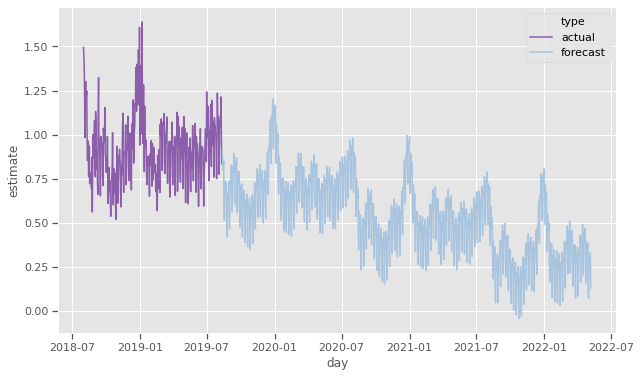

In [570]:
fig, ax = plt.subplots(figsize=(10,6))
df = all_forecasts.query('series == "single_gift_subs_rev_T2_per_khw"')
sns.lineplot(x=df['day'],
             y=df['estimate'],
             hue=df['type'],
             palette='BuPu_r',
             ax=ax);

In [584]:
daily_revenue = pd.read_csv("./creators/daily_revenue_by_source.csv", parse_dates=['day'])

In [585]:
daily_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5061 entries, 0 to 5060
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   day                              5061 non-null   datetime64[ns]
 1   country_tier                     5061 non-null   object        
 2   hours_watched                    5061 non-null   float64       
 3   paid_bits_revenue_net            5061 non-null   float64       
 4   unpaid_bits_revenue_net          5061 non-null   float64       
 5   channel_subs_revenue_net         5061 non-null   float64       
 6   community_gift_subs_revenue_net  5061 non-null   float64       
 7   single_gift_subs_revenue_net     5061 non-null   float64       
 8   prime_subs_revenue_net           5061 non-null   float64       
 9   ad_revenue_creator               5061 non-null   float64       
 10  ad_revenue_net                   1137 non-null   float64    

### Retain reliable data

In [579]:
max_date = pd.to_datetime("2019-08-01")
min_date = max_date - pd.Timedelta(3*365, unit='D')

In [599]:
daily_revenue = daily_revenue[(daily_revenue['day'] > min_date) & (daily_revenue['day'] <= max_date)]

In [600]:
daily_revenue

,day,country_tier,hours_watched,paid_bits_revenue_net,unpaid_bits_revenue_net,channel_subs_revenue_net,community_gift_subs_revenue_net,single_gift_subs_revenue_net,prime_subs_revenue_net,ad_revenue_creator,ad_revenue_net,revenue_total
1737,2016-08-02,T1,6.439066e+06,1125.891700,0.00,49666.2180,0.000,0.000,0.000,16180.922500,NaN,NaN
1738,2016-08-02,T2,4.541239e+06,205.909480,0.00,12375.9970,0.000,0.000,0.000,5725.450671,NaN,NaN
1739,2016-08-02,T3,2.057355e+06,15.363300,0.00,5073.4600,0.000,0.000,0.000,2035.354628,NaN,NaN
1740,2016-08-03,T1,6.654472e+06,501.989300,-0.96,45254.3537,0.000,0.000,0.000,13734.316118,NaN,NaN
1741,2016-08-03,T2,4.964028e+06,104.779000,0.00,12456.8240,0.000,0.000,0.000,4743.005793,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5017,2019-07-31,T2,7.035272e+06,11050.286589,-1250.56,29720.7280,29157.149,7808.661,-34930.685,21532.233453,36868.471490,78424.051078
5018,2019-07-31,T3,3.439888e+06,3901.162256,-1601.66,10549.6850,10922.602,3030.592,-20508.512,6649.065461,7581.760170,13875.629426
5019,2019-08-01,T1,1.627533e+07,72302.601297,-7061.11,197305.9900,142861.252,37366.533,-173237.813,45546.542299,269884.228500,539421.681797
5020,2019-08-01,T2,7.572156e+06,11697.482151,-334.68,41529.1140,38982.786,8180.861,-34762.114,30019.668664,18559.431276,83852.880427


### Smooth Bits Promo (99c for 500 bits) [Interpolate 4/16/18 through 4/24/18 inclusive]

In [606]:
# Tier 1 correction
paid_bits_historical_T1 = daily_revenue[(daily_revenue['day'] >= '2016-06-27') &
                                        (daily_revenue['day'] <= '2018-04-15') &
                                        (daily_revenue['country_tier'] == 'T1')] \
                          .rename({'paid_bits_revenue_net': 'y',
                                   'day': 'ds'}, axis='columns')

In [610]:
m_rev_T1 = Prophet(**prophet_params).fit(paid_bits_historical_T1)
future_rev_T1 = m_rev_T1.make_future_dataframe(periods=6)
forecast_rev_T1 = m_rev_T1.predict(future_rev_T1)

In [613]:
smoothed_bits_T1 = forecast_rev_T1.query('ds > "2018-04-15"')[['ds', 'yhat']]

In [625]:
daily_revenue = pd.merge(daily_revenue, smoothed_bits_T1, how='left', left_on='day', right_on='ds')

In [668]:
daily_revenue['paid_bits_revenue_net'] = daily_revenue['yhat'].where(
               (daily_revenue['day'] > pd.to_datetime("2018-04-15")) &
               (daily_revenue['day'] < pd.to_datetime("2018-04-24")) &
               (daily_revenue['country_tier'] == 'T1'),
    daily_revenue['paid_bits_revenue_net'], axis=0)

daily_revenue.drop(['ds', 'yhat'], axis=1, inplace=True)

In [671]:
# Tier 2 correction
paid_bits_historical_T2 = daily_revenue[(daily_revenue['day'] >= '2016-06-27') &
                                        (daily_revenue['day'] <= '2018-04-15') &
                                        (daily_revenue['country_tier'] == 'T2')] \
                          .rename({'paid_bits_revenue_net': 'y',
                                   'day': 'ds'}, axis='columns')

m_rev_T2 = Prophet(**prophet_params).fit(paid_bits_historical_T2)
future_rev_T2 = m_rev_T2.make_future_dataframe(periods=6)
forecast_rev_T2 = m_rev_T2.predict(future_rev_T2)

smoothed_bits_T2 = forecast_rev_T2.query('ds > "2018-04-15"')[['ds', 'yhat']]
daily_revenue = pd.merge(daily_revenue, smoothed_bits_T2, how='left', left_on='day', right_on='ds')

daily_revenue['paid_bits_revenue_net'] = daily_revenue['yhat'].where(
               (daily_revenue['day'] > pd.to_datetime("2018-04-15")) &
               (daily_revenue['day'] < pd.to_datetime("2018-04-24")) &
               (daily_revenue['country_tier'] == 'T2'),
    daily_revenue['paid_bits_revenue_net'], axis=0)

daily_revenue.drop(['ds', 'yhat'], axis=1, inplace=True)

In [673]:
# Tier 3 correction
paid_bits_historical_T3 = daily_revenue[(daily_revenue['day'] >= '2016-06-27') &
                                        (daily_revenue['day'] <= '2018-04-15') &
                                        (daily_revenue['country_tier'] == 'T3')] \
                          .rename({'paid_bits_revenue_net': 'y',
                                   'day': 'ds'}, axis='columns')

m_rev_T3 = Prophet(**prophet_params).fit(paid_bits_historical_T3)
future_rev_T3 = m_rev_T3.make_future_dataframe(periods=6)
forecast_rev_T3 = m_rev_T3.predict(future_rev_T3)

smoothed_bits_T3 = forecast_rev_T3.query('ds > "2018-04-15"')[['ds', 'yhat']]
daily_revenue = pd.merge(daily_revenue, smoothed_bits_T3, how='left', left_on='day', right_on='ds')

daily_revenue['paid_bits_revenue_net'] = daily_revenue['yhat'].where(
               (daily_revenue['day'] > pd.to_datetime("2018-04-15")) &
               (daily_revenue['day'] < pd.to_datetime("2018-04-24")) &
               (daily_revenue['country_tier'] == 'T2'),
    daily_revenue['paid_bits_revenue_net'], axis=0)

daily_revenue.drop(['ds', 'yhat'], axis=1, inplace=True)